In [27]:
import sys
sys.path.append('../')

In [28]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
from diffusers import UNet2DModel

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
IMG_SIZE = 32

In [31]:
# Transformations
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
)

undo_transform = transforms.Compose(
    [
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: (t * 255.0).numpy().astype(np.uint8)),
    ]
)

In [32]:
class diffusion:
    def __init__(self, timesteps, scheduler_type=None):
        betas = torch.linspace(0.0001, 0.02, timesteps)

        alphas = 1 - betas
        sqrt_alphas = torch.sqrt(alphas)
        alpha_hats = torch.cumprod(1 - betas, axis=0)
        sqrt_alpha_hats = torch.sqrt(alpha_hats)

        sqrt_one_minus_alpha_hats = torch.sqrt(1 - alpha_hats)

        self.betas = betas
        self.alphas = alphas
        self.sqrt_alphas = sqrt_alphas
        self.alpha_hats = alpha_hats
        self.sqrt_alpha_hats = sqrt_alpha_hats
        self.sqrt_one_minus_alpha_hats = sqrt_one_minus_alpha_hats

    def noise_schedule(self, x_0, t, device="cpu"):
        noise = torch.randn(size=x_0.shape)

        alpha_hats_t = self.alpha_hats[t]
        alpha_hats_t = alpha_hats_t.reshape(shape=(t.shape[0], 1, 1, 1))

        sqrt_alpha_hats_t = self.sqrt_alpha_hats[t]
        sqrt_alpha_hats_t = sqrt_alpha_hats_t.reshape(shape=(t.shape[0], 1, 1, 1))

        sqrt_one_minus_alpha_hats_t = self.sqrt_one_minus_alpha_hats[t]
        sqrt_one_minus_alpha_hats_t = sqrt_one_minus_alpha_hats_t.reshape(
            shape=(t.shape[0], 1, 1, 1)
        )

        mean = sqrt_alpha_hats_t * x_0
        variance = sqrt_one_minus_alpha_hats_t * noise

        x_ts = mean + variance

        return x_ts.to(device), noise.to(device)

    @torch.no_grad()
    def sample(self, x_t, t, prediction):
        x_t = x_t.cpu()
        t = t.cpu()
        prediction = prediction.cpu()

        betas_t = self.betas[t]
        sqrt_alphas_t = self.sqrt_alphas[t]

        sqrt_one_minus_alpha_hats_t = self.sqrt_one_minus_alpha_hats[t]

        x_t_minus_one = (1 / sqrt_alphas_t) * (
            x_t - ((betas_t * prediction) / sqrt_one_minus_alpha_hats_t)
        )

        if t == 0:
            return x_t_minus_one
        else:
            noise = torch.randn_like(x_t)
            return x_t_minus_one + torch.sqrt(betas_t) * noise
        
    @torch.no_grad()
    def create_image(self, model, img_size=32, timesteps=300, num_channels=3):
        img = torch.randn((1, num_channels, img_size, img_size))
        plt.figure(figsize=(15, 2))
        plt.axis("off")
        num_images = 10
        stepsize = int(timesteps / num_images)

        for i in range(0, timesteps)[::-1]:
            t = torch.full((1,), i, dtype=torch.long)

            img = img.to(device)
            t = t.to(device)

            prediction = model(img, t).sample

            img = self.sample(img, t, prediction)

            img = torch.clamp(img, -1.0, 1.0)
            if i % stepsize == 0:
                plt.subplot(1, num_images, int(i / stepsize) + 1)
                plt.imshow(undo_transform(img.cpu()[0]))
        plt.show()
        return img.cpu()[0]

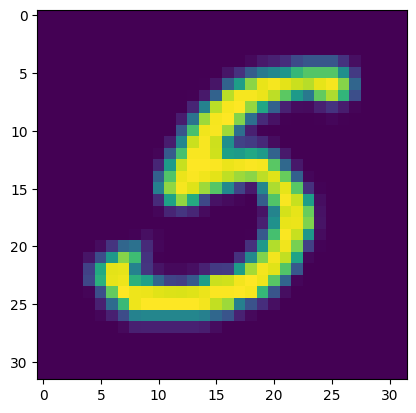

In [33]:
image_data = torchvision.datasets.QMNIST("../data", download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(image_data, batch_size=16, shuffle=True)
images, labels = next(iter(data_loader))
plt.imshow(undo_transform(images[0]))

In [34]:
BATCH_SIZE = 16
NO_EPOCHS = 25
TIME_STEPS = 300

diffuser = diffusion(timesteps=TIME_STEPS)

Epoch 0 | step 000 Loss: 1.1740615367889404 
Using 11.65 GB


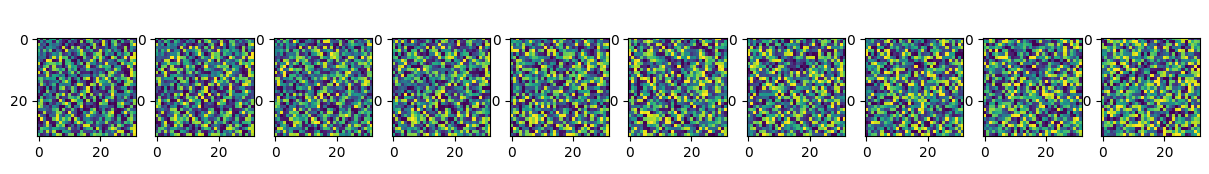

Epoch 1 | step 000 Loss: 0.04009338468313217 
Using 11.60 GB


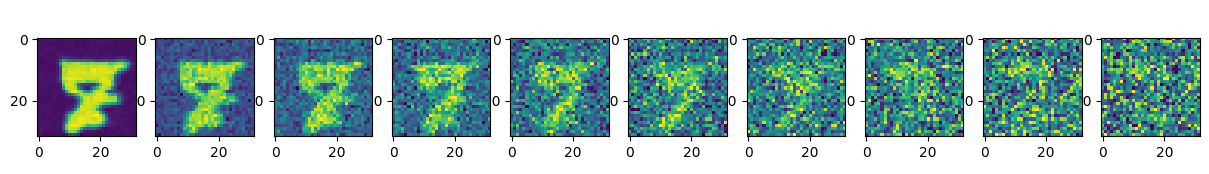

Epoch 2 | step 000 Loss: 0.028752319514751434 
Using 11.60 GB


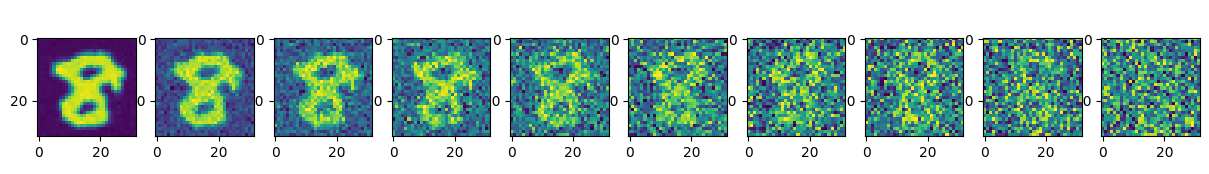

Epoch 3 | step 000 Loss: 0.025385014712810516 
Using 11.60 GB


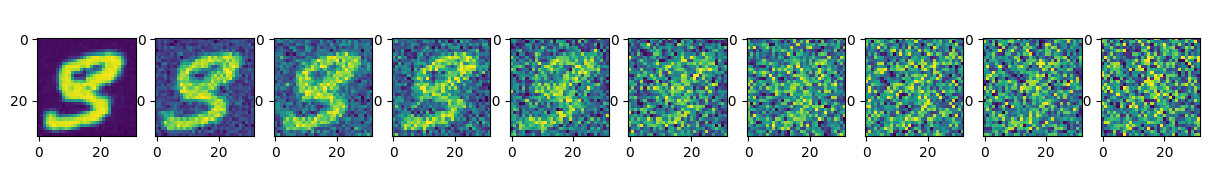

Epoch 4 | step 000 Loss: 0.02398667111992836 
Using 11.60 GB


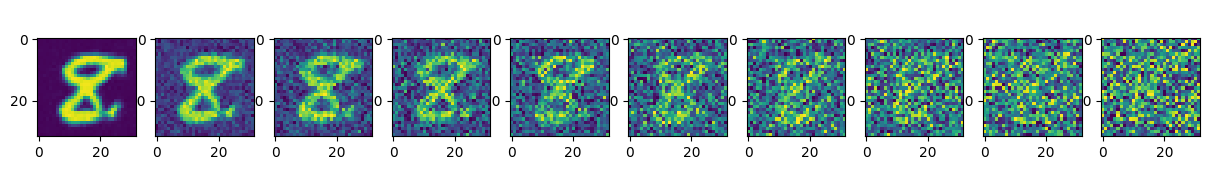

Epoch 5 | step 000 Loss: 0.025239329785108566 
Using 11.60 GB


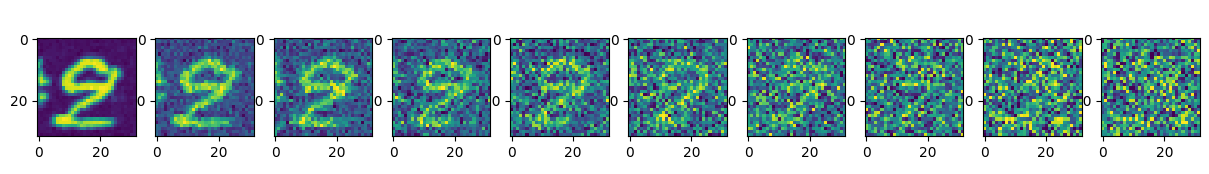

Epoch 6 | step 000 Loss: 0.04922228306531906 
Using 11.60 GB


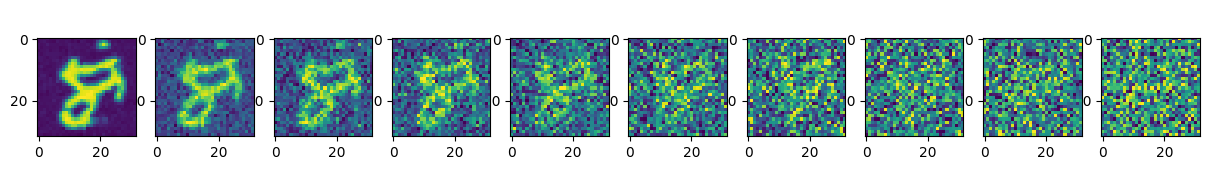

Epoch 7 | step 000 Loss: 0.03621089085936546 
Using 11.60 GB


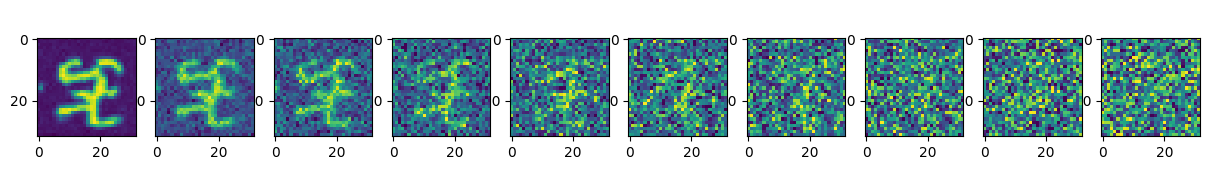

Epoch 8 | step 000 Loss: 0.02089357003569603 
Using 11.60 GB


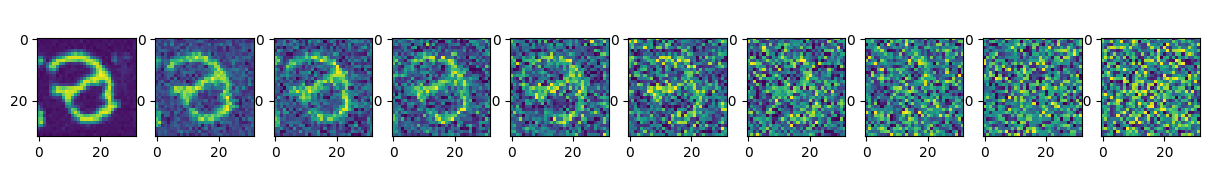

Epoch 9 | step 000 Loss: 0.03083128109574318 
Using 11.60 GB


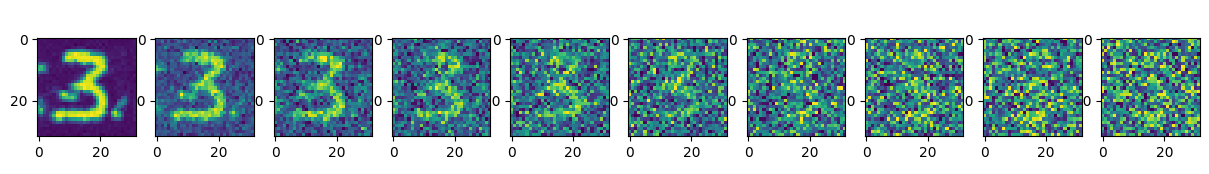

Epoch 10 | step 000 Loss: 0.019815238192677498 
Using 11.60 GB


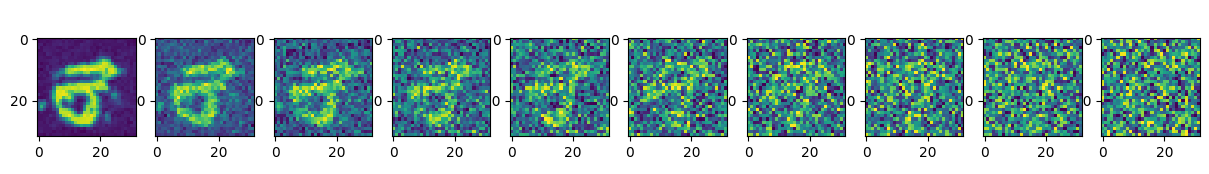

Epoch 11 | step 000 Loss: 0.019301651045680046 
Using 11.60 GB


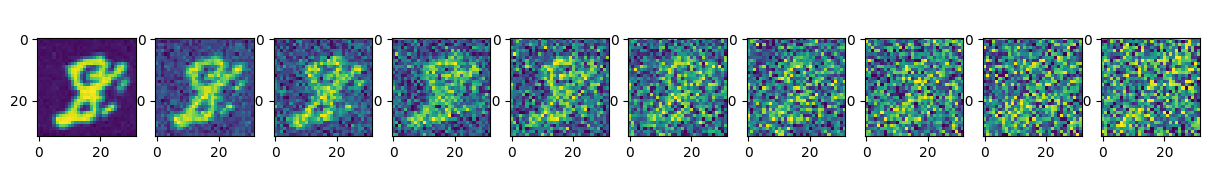

Epoch 12 | step 000 Loss: 0.04666909575462341 
Using 11.60 GB


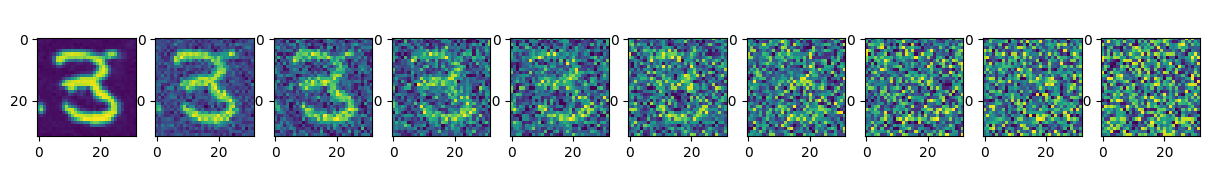

Epoch 13 | step 000 Loss: 0.022947028279304504 
Using 11.60 GB


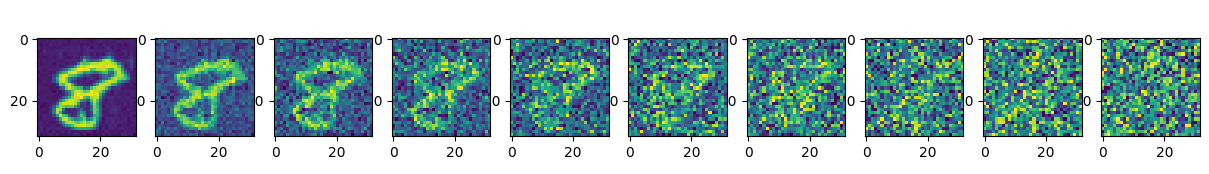

Epoch 14 | step 000 Loss: 0.035479046404361725 
Using 11.60 GB


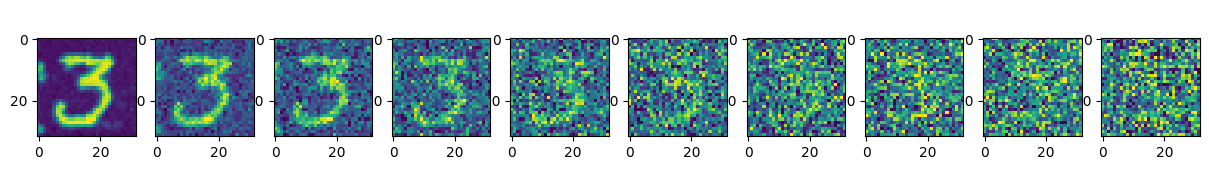

Epoch 15 | step 000 Loss: 0.024685662239789963 
Using 11.60 GB


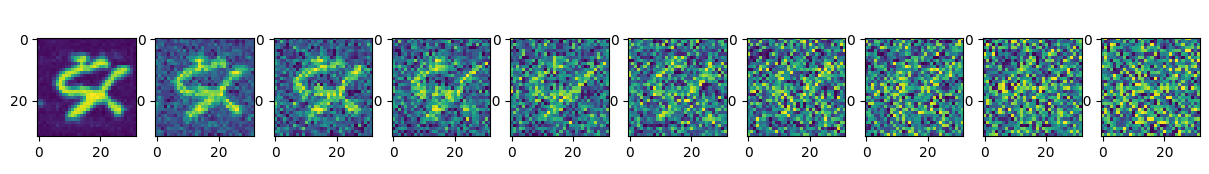

Epoch 16 | step 000 Loss: 0.03445613756775856 
Using 11.60 GB


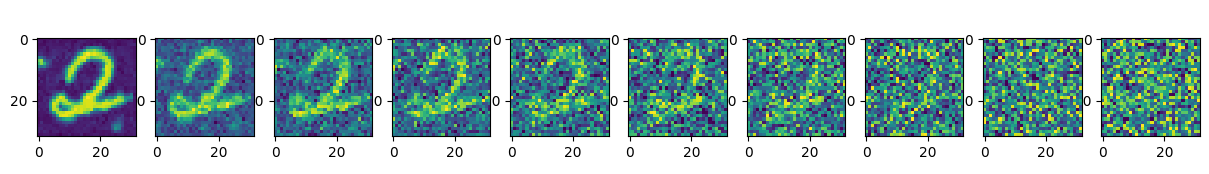

Epoch 17 | step 000 Loss: 0.0265253446996212 
Using 11.60 GB


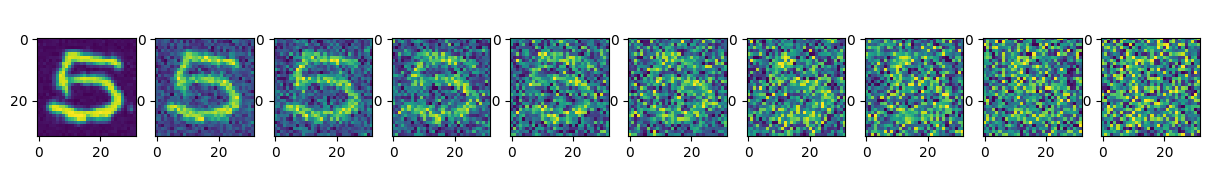

Epoch 18 | step 000 Loss: 0.028397081419825554 
Using 11.60 GB


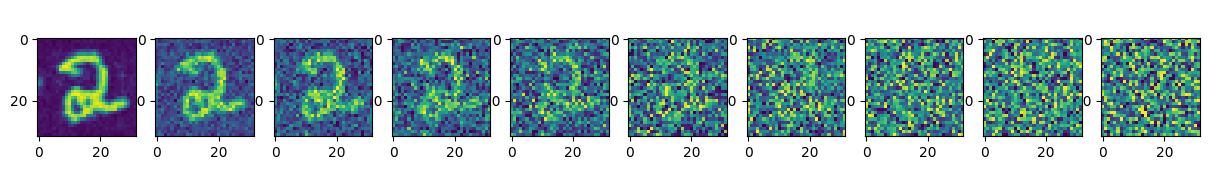

Epoch 19 | step 000 Loss: 0.025012318044900894 
Using 11.60 GB


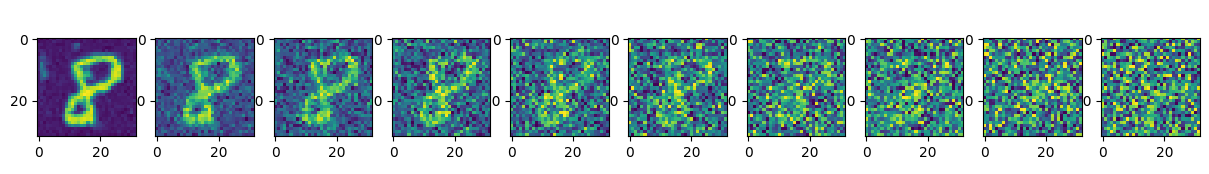

Epoch 20 | step 000 Loss: 0.034265369176864624 
Using 11.60 GB


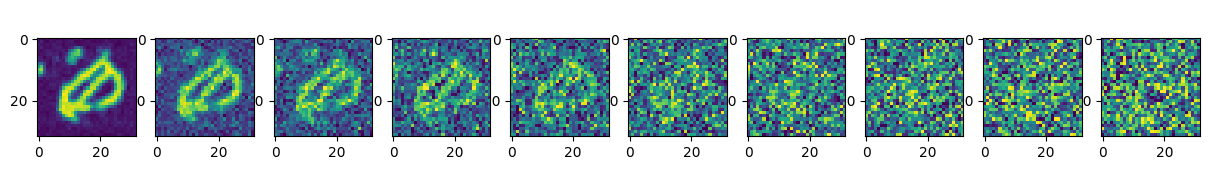

Epoch 21 | step 000 Loss: 0.023653116077184677 
Using 11.60 GB


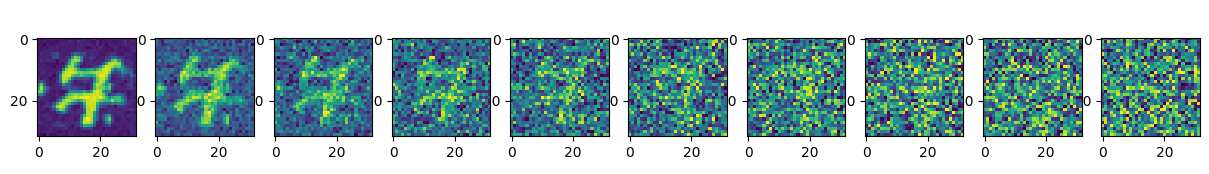

Epoch 22 | step 000 Loss: 0.022250056266784668 
Using 11.60 GB


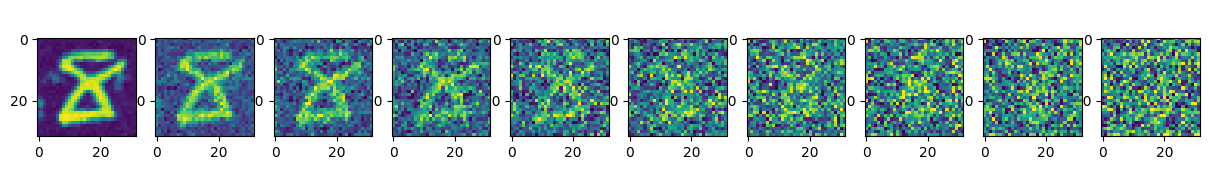

Epoch 23 | step 000 Loss: 0.021345634013414383 
Using 11.60 GB


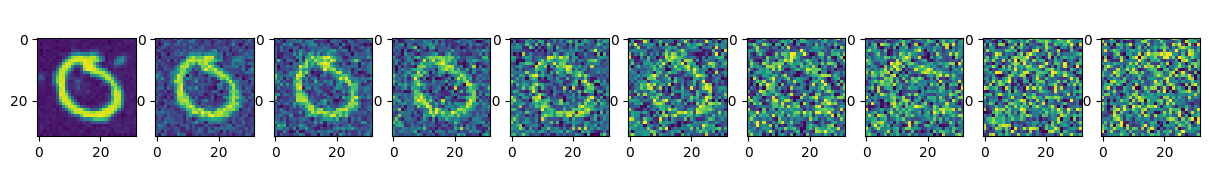

Epoch 24 | step 000 Loss: 0.04395432770252228 
Using 11.60 GB


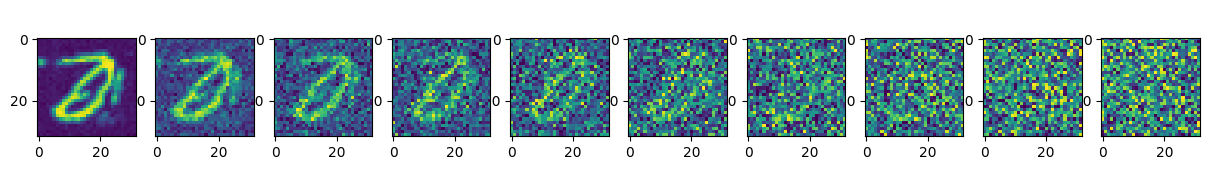

In [35]:
model = UNet2DModel(
    sample_size=IMG_SIZE,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(IMG_SIZE, IMG_SIZE*2, IMG_SIZE*4, IMG_SIZE*8),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
    ),
    dropout=0.1
)

model.to(device)

dataloader = torch.utils.data.DataLoader(
    image_data, batch_size=BATCH_SIZE, shuffle=True
)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2*1e-4)

for epoch in range(NO_EPOCHS):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, TIME_STEPS, (len(batch[0]),), device=device).long()

        img_batch_noisy, noise_batch = diffuser.noise_schedule(
            x_0=batch[0], t=t.cpu(), device=device
        )

        predicted_noise_batch = model(img_batch_noisy, t)

        loss = loss_fn(predicted_noise_batch.sample, noise_batch)

        loss.backward()
        optimizer.step()

        if step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            print(f"Using {torch.cuda.mem_get_info()[0]/1000000000:.2f} GB")
            diffuser.create_image(model, img_size=IMG_SIZE, timesteps=TIME_STEPS, num_channels=1)

model.save_pretrained("../checkpoints/model_MNIST_checkpoint/", from_pt=True)

In [36]:
model_new = UNet2DModel().from_pretrained("../checkpoints/model_MNIST_checkpoint/")
model_new = model_new.to(device)

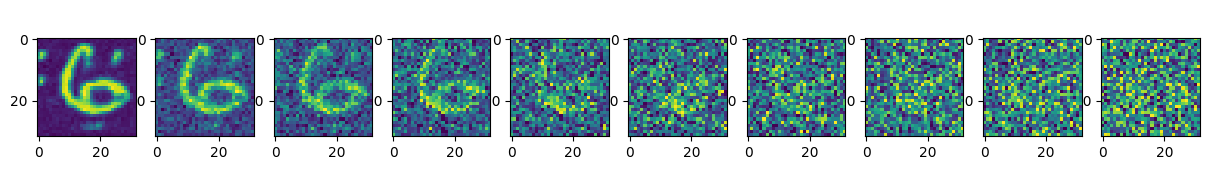

In [37]:
img = diffuser.create_image(model_new, img_size=IMG_SIZE, timesteps=TIME_STEPS, num_channels=1)

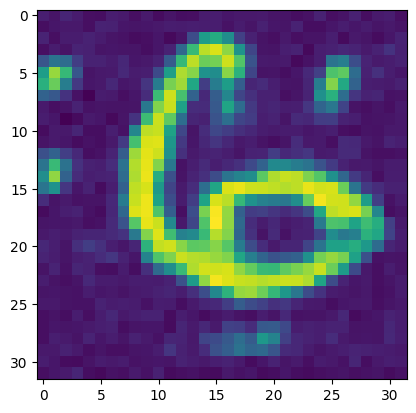

In [38]:
img.cpu()
plt.imshow(undo_transform(img.cpu()))